# Correlation matrix

In [37]:
import h5py
import pandas as pd
import seaborn as sns
from scipy.io import loadmat

%pylab inline
matplotlib.rcParams['figure.figsize'] = (40.0, 40.0)

Populating the interactive namespace from numpy and matplotlib


/data/akmorrow/anaconda2/envs/python36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'mean', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
# Users set datafile filepath
datafile = "/data/epitome/tmp/deepsea_train/valid.mat"
deepsea_dev_results = "/data/epitome/tmp/deepsea_train/valid.mat" # TODO
epitome_dev_results = None # TODO
valid = True

In [ ]:
# location of labels 
namefile = './deepsea_label_names.txt'

In [114]:
# get positions for LCL and Embryonic cell lines
gm12878_positions = [(i,j) for i, j in enumerate(names) if 'GM12878' in j and 'DNase' not in j]
h1hesc_positions = [(i,j) for i, j in enumerate(names) if 'H1-hESC' in j and 'DNase' not in j]


gm12878_tfs =  [i[1].split('|')[1] for i in gm12878_positions]
h1hesc_tfs =  [i[1].split('|')[1] for i in h1hesc_positions]

overlapping_tfs = list(set(gm12878_tfs) & set(h1hesc_tfs))


gm12878_final_positions = [(i,j) for i, j in gm12878_positions if j.split('|')[1] in overlapping_tfs]
h1hesc_final_positions = [(i,j) for i, j in  h1hesc_positions if j.split('|')[1] in overlapping_tfs]


# filter out duplicates
gm12878_items = []
seen = set()
for item in gm12878_final_positions:
    if not item[1] in seen:
        seen.add(item[1])
        gm12878_items.append(item)
        
gm12878_items = sorted(gm12878_items, key=lambda i: i[1]) 
        
        
h1hesc_items = []
seen = set()
for item in h1hesc_final_positions:
    if not item[1] in seen:
        seen.add(item[1])
        h1hesc_items.append(item)
        
h1hesc_items = sorted(h1hesc_items, key=lambda i: i[1])

hela_names = names[names.tolist().index('HeLa-S3|AP-2alpha|None'):(names.tolist().index('HeLa-S3|ZZZ3|None') +1)]

# verify that these TFs match
for i, item in enumerate(h1hesc_items):
    assert(h1hesc_items[i][1].split('|')[1]==gm12878_items[i][1].split('|')[1])

    
# These are the indices we are using for the GM12878 model
gm12878_indices = list(map(lambda x: x[0], gm12878_items))
h1hesc_indices = list(map(lambda x: x[0], h1hesc_items))

gm12878_names = names[gm12878_indices]
h1hesc_names = names[h1hesc_indices ]

# all transcription factors
tf_names = names[125:815]  

In [116]:
def load_names(namefile):
    return np.array(open(namefile).read().split(','))

def load_train_data(datafile, namefile):
    data_hdf5 = h5py.File(datafile)['traindata']
    return (data_hdf5, load_names(namefile))

def load_valid_data(datafile, namefile):
    data_hdf5 = loadmat(datafile)['validdata']
    return (data_hdf5, load_names(namefile))

def subsample_train(data_hdf5, n):
    N = data_hdf5.shape[-1]
    indices = sorted(np.random.choice(
        N, n, replace=False))
    return data_hdf5[:,indices].T

def subsample_valid(data_mat, n):
    N = data_mat.shape[0]
    indices = sorted(np.random.choice(
        N, n, replace=False))
    return data_mat[indices,:]

if (valid):
    data_hdf5, names = load_valid_data(datafile, namefile)
else:
    data_hdf5, names = load_train_data(datafile, namefile)

# subsample data
if (valid):
    X = subsample_valid(data_hdf5, n=5000)
else:
    X = subsample(data_hdf5, n=5000)


# features with no binding events
nan_names = names[np.equal(np.sum(X, axis=0), 0)]

# compute correlation matrix
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
Z = (X - mean) / (std + 1e-9)  # ignore warning...
C = Z.T.dot(Z) / Z.shape[0]

# convert to dataframe
df = pd.DataFrame(C)
df.columns = names
df.index = names

# drop duplicate features
indices = [list(names).index(x) for x in set(names)]
df = df.iloc[indices, indices]

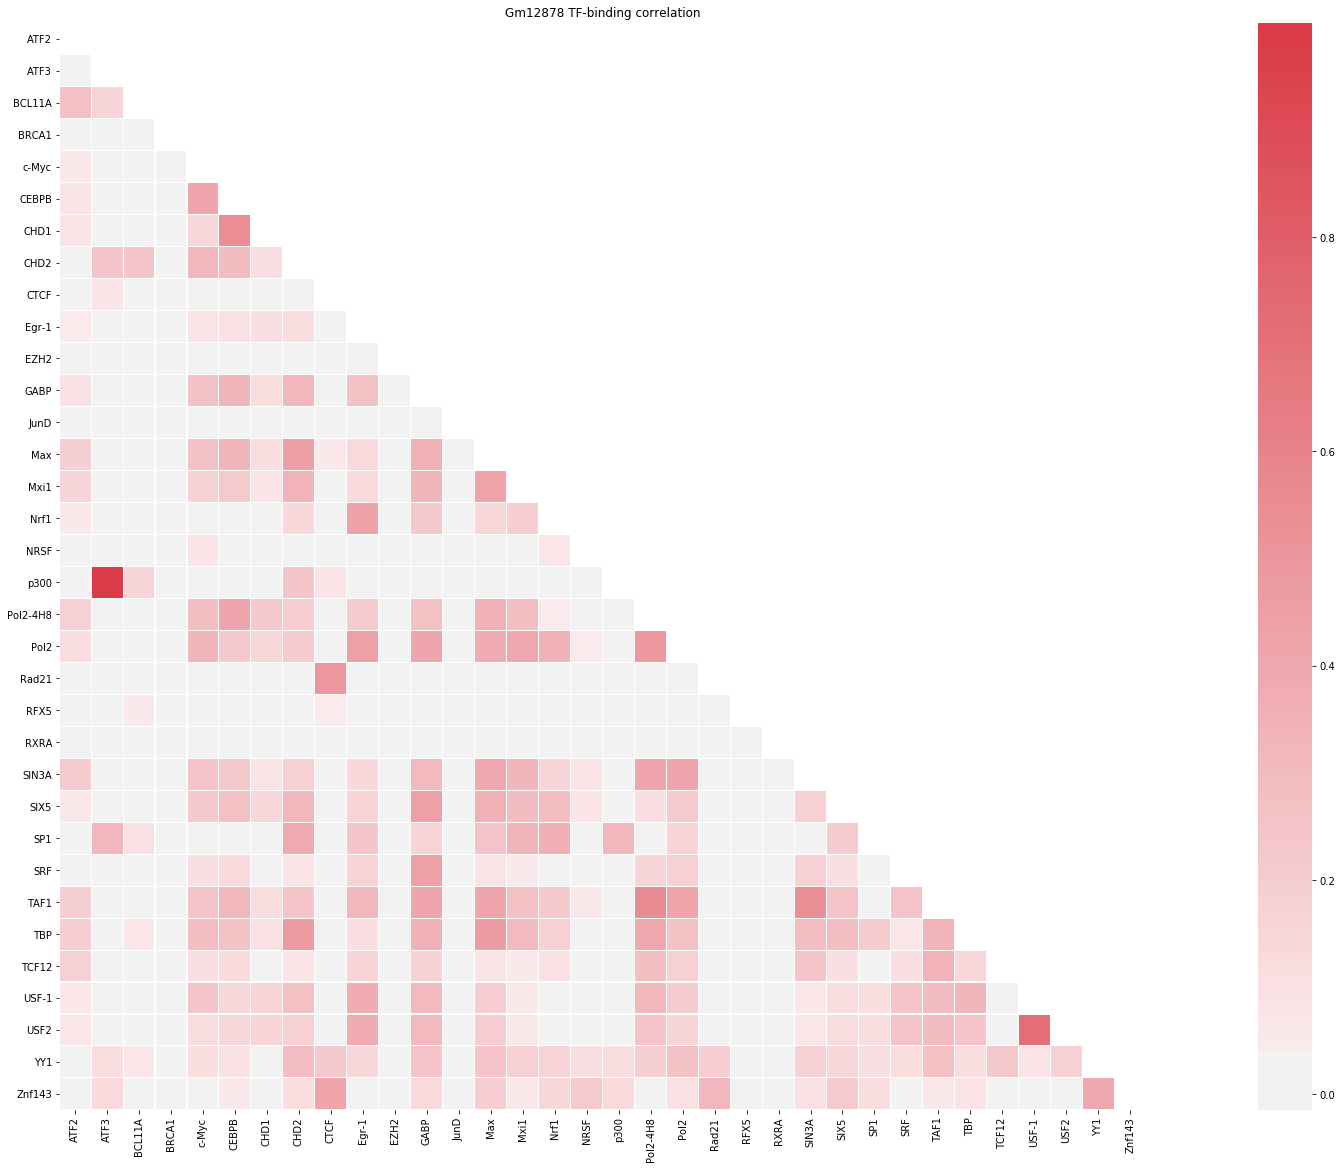

In [117]:
def plot_correlation(df, **kwargs):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    def maybe_add(kwargs, key, value):
        if key not in kwargs:
            kwargs[key] = value
    maybe_add(kwargs, 'mask', mask)
    maybe_add(kwargs, 'cmap', cmap)
    maybe_add(kwargs, 'linewidths', 0)  # 0.05
    maybe_add(kwargs, 'square', True)
    maybe_add(kwargs, 'center', 0)
    sns.heatmap(df, **kwargs)

# filter features
filter_fn = lambda x: (x in gm12878_names)
filtered_names = np.unique(list(filter(filter_fn, names)))


filtered_names = sorted(filtered_names, key=str.lower)
filtered_df = df.loc[filtered_names, filtered_names]

# pretty names for printing
filtered_df.columns = [x.split('|')[1] for x in filtered_df.columns]
filtered_df.index = [x.split('|')[1] for x in filtered_df.index]

plt.figure(figsize=(40.0, 20.0))
plt.title('Gm12878 TF-binding correlation')
plot_correlation(filtered_df, linewidths=0.05)

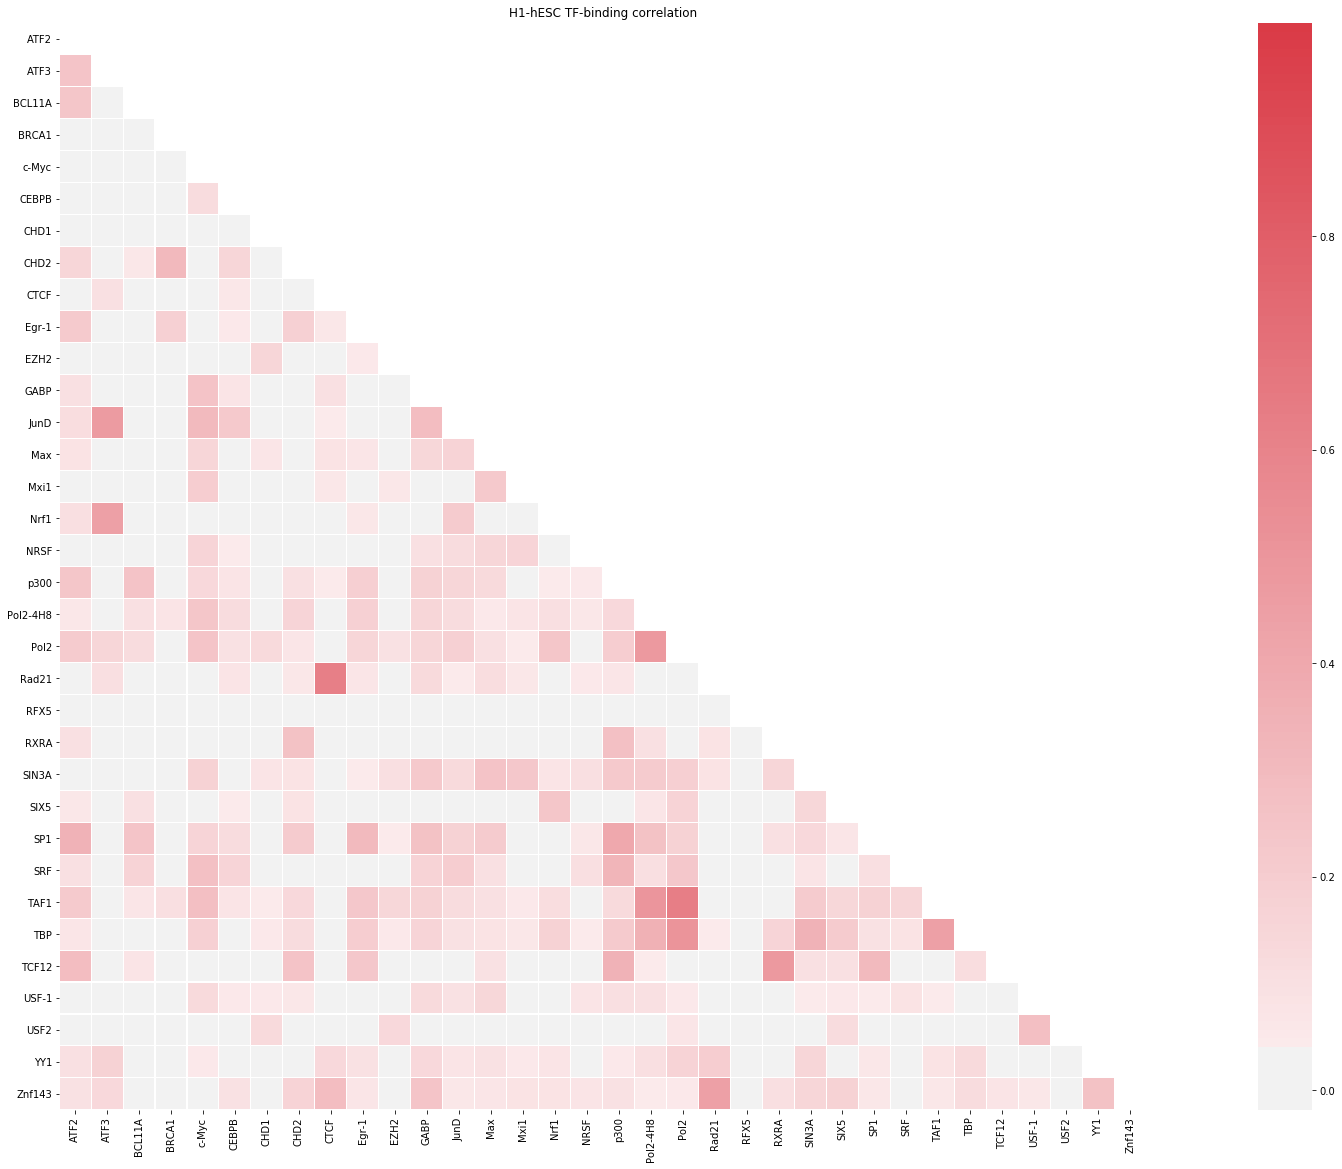

In [83]:
# filter features
filter_fn = lambda x: (x in h1hesc_names)
filtered_names = np.unique(list(filter(filter_fn, names)))


filtered_names = sorted(filtered_names, key=str.lower)
filtered_df = df.loc[filtered_names, filtered_names]

# pretty names for printing
filtered_df.columns = [x.split('|')[1] for x in filtered_df.columns]
filtered_df.index = [x.split('|')[1] for x in filtered_df.index]

plt.figure(figsize=(40.0, 20.0))
plt.title('H1-hESC TF-binding correlation')
plot_correlation(filtered_df, linewidths=0.05)

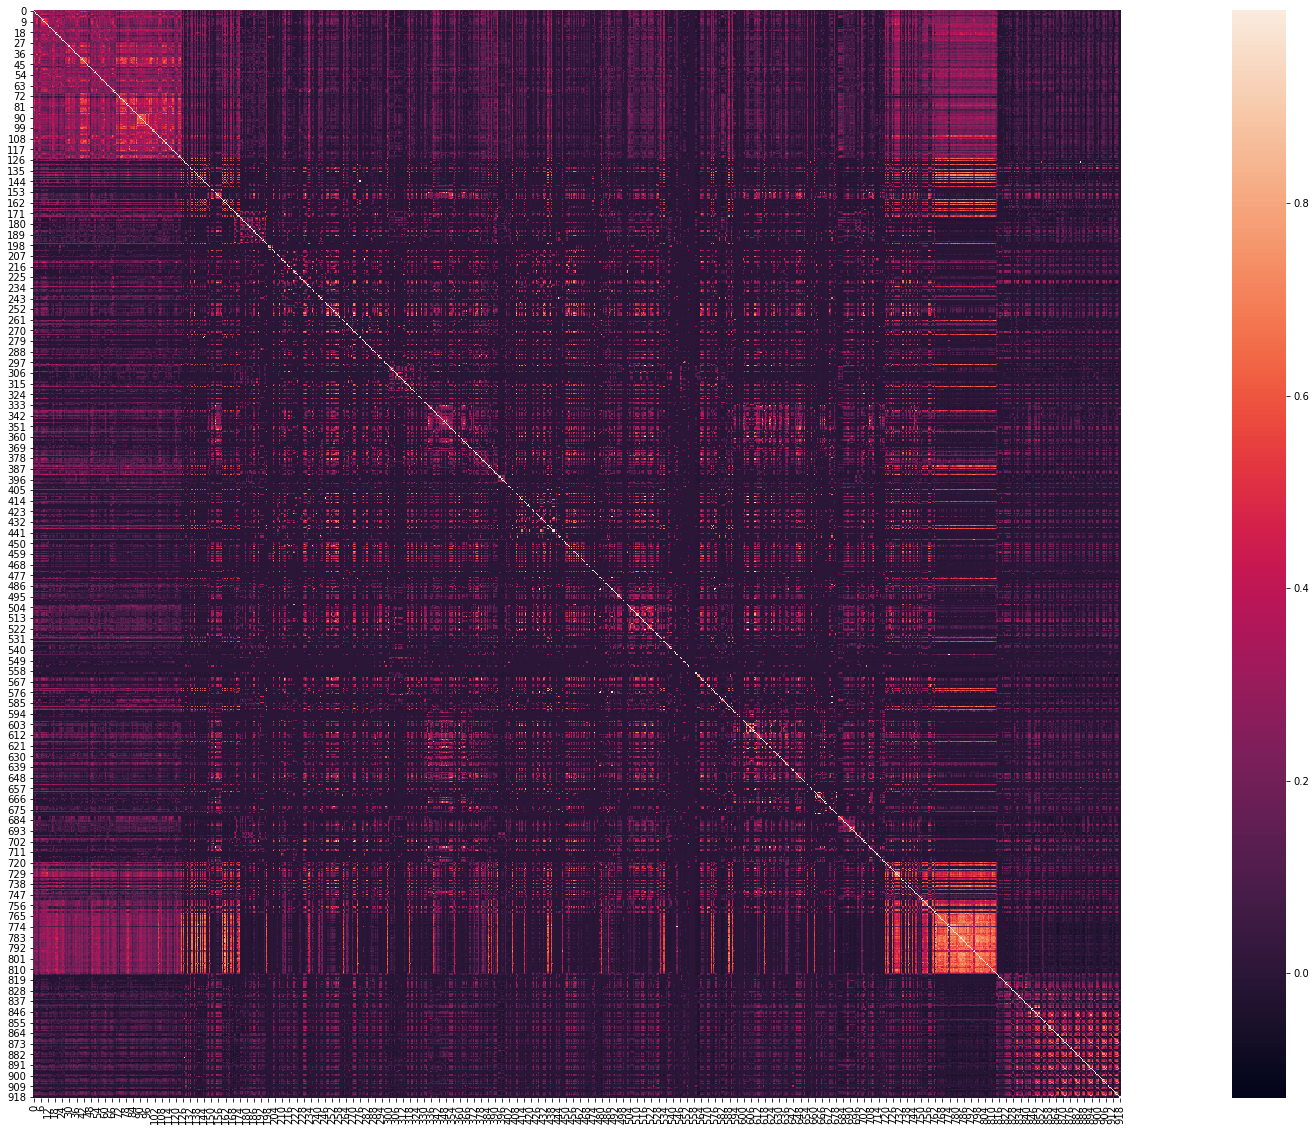

In [33]:
# all 919 features
plt.figure(figsize=(40.0, 20.0))
sns.heatmap(C, square=True);